# A/B Testing Example
__By Enrico Tomassoli, PhD, MS__

### 0. Importing Libraries
In the following the Python libraries are imported. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

### 1. Importing Data
The data for the A/B test can be found using the following link in _Kaggle_:

https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv

The data is downloaded and saved in csv format, and the file name is _ab_data.csv_ also saved in the folder. The first few rows of the data are shown in the following. Info and description of the data are reported as well.

In [3]:
rd = pd.read_csv('ab_data.csv') # Data is loaded
rd.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [4]:
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
rd.describe(include=None)

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In the date we also check for duplicates. It appears that there are approximately 4,000 user that reported in the data multiple times.

In [6]:
print('Number of duplicate user ID removed =',(rd.user_id.shape[0] - len(rd.user_id.unique())))
rd.drop_duplicates('user_id',keep='first',inplace=True)

Number of duplicate user ID removed = 3894


### 2. Sample Size Estimation
The assumption in this study is that the current conversion rate is approximately 13%, and increases it by 2% would be acceptable, i.e. that new feature/design will provide a 15% conversion rate. This allows to evaluate the size of the sample for our analysis. Since getting the data is expensive and time consuming, we want to use the "minimum" amount of samples. We also fixed the following values:
- ___Alpha α = 0.05___
- ___β = 0.20___
- ___Power of the Test = (1-β) = 0.80___

In [7]:
# Calculating effect size starting from expectation rates
eff_size = sms.proportion_effectsize(0.13,0.15)
n_required = int(sms.NormalIndPower().solve_power(eff_size, power=0.80, alpha=0.05, ratio=1))
print('Minimum Sample Size Required =',n_required)

Minimum Sample Size Required = 4719


This number should be defined before starting collection data. In this case, the sample size is very small in comparison to the data available. In particular is a very small percentage:

In [8]:
print('Sample Percentage Respect to All Data Available =', round(n_required/rd.shape[0]*100,3),'%')

Sample Percentage Respect to All Data Available = 1.624 %


### 2.1. Impact of Target Conversion Rate
Below quick estimation of the sample size considering the target conversion rate. This is just an exercise to show the impact of the sample size to considered, similar to a sensitive analysis. The number of sample is evaluated for different target conversion rate to show that, when the _gap_ between current and target rate increase, the number of samples drop dramatically. In other words, if we expect that the action we take to improve the conversion rate is significant, less date is available since the results, in a way, should be overwhelming. On the contrary, when the _gap_ is smaller, more data is necessary to better justify statistically the results to support or reject the proposed action.

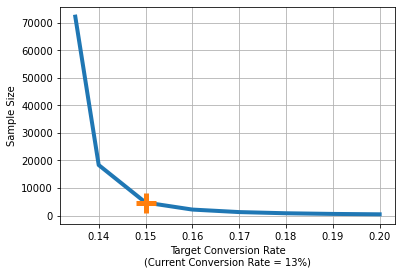

In [9]:
cr_target = [0.135, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20] # Target conversion rates
n_sample = [] 

# Loop to estimate number of samples for different conversion rates
for i in cr_target:
    n_sample.append(int(sms.NormalIndPower().solve_power(sms.proportion_effectsize(0.13,i), power=0.80, alpha=0.05, ratio=1)))

# Results are plot    
plt.plot(cr_target,n_sample,linewidth=4)
plt.xlabel('Target Conversion Rate\n(Current Conversion Rate = 13%)')
plt.ylabel('Sample Size')
plt.grid()
plt.plot([0.15],[n_required],marker='+',markersize=20,markeredgewidth=5)   
plt.show()

### 2.2. Sample Selection
Assuming a conversion  converson rate of 13% and a target one of 15%, we calculated that a sample of approximately 5,000 observation is needed. Since the data available is much larger, a sample of 20,000 is considered instead, in order to have a more accurate analysis.

In [10]:
# Randomly extract a sample from the raw data DataFrame
# First the raw data is filtered, then the sample is extracted in order to have the same number of data points in each group
n = 4719
sample_contr = rd[rd['group']=='control'] ['converted'].sample(n=n, random_state=42)
sample_treat = rd[rd['group']=='treatment'] ['converted'].sample(n=n, random_state=42)

### 3. Results
After the sample is extracted, mean and standard deviation can be calculated for the conversion rate in both ___Control___ and ___Treatment___ group.

In [11]:
print(f'Control Group Sample Mean  : {sample_contr.mean():.4f}')
print(f'Treatment Group Sample Mean: {sample_treat.mean():.4f}')

Control Group Sample Mean  : 0.1261
Treatment Group Sample Mean: 0.1127


From the results above, it seems that the difference between the two group is minor. It also appears that the treatment group "perform" even worst that the control group, meaning that the new feature not only does not provide any benefits, but it also affects negatively the conversion rate.

__NOTE:__ In addition, the Treatment Group shows a value that is "far" from the 15% hoped target.

### 4. Hypothesis Test
Even if it appears that the effect is irrelevant, this must be decided statistically trying to confimr or reject the ___Null Hypothesys___:
- H0 (Null Hypothesis): The new feature has not effect on the conversion rate
- H1 (Alternative Hypothesis : The new feature has an effect on the conversion rate

In [12]:
z_stat, pval = proportions_ztest([sample_contr.sum(),sample_treat.sum()],       # Number of successful conversion (count)
                                 [sample_contr.count(),sample_treat.count()],   # Number of observations (nobs)
                                  value=0)
ci_low, ci_upp = proportion_confint([sample_contr.sum(),sample_treat.sum()],       # Number of successful conversion (count)
                   [sample_contr.count(),sample_treat.count()],   # Number of observations (nobs)
                   alpha=0.05,                                    # Significant defalut, 5%
                   method='normal')                               # Method for confident interval calculation

In [13]:
print(f'Numer of Sample for Each Group    : {n}')
print(f'Z-statistic                       : {z_stat:.3f}')
print(f'P-value                           : {pval:.3f}')
print(f'Control Group 95% Conf. Interval  : [{ci_low[0]:.3f}, {ci_upp[0]:.3f}]')
print(f'Treatment Group 95% Conf. Interval: [{ci_low[1]:.3f}, {ci_upp[1]:.3f}]')

Numer of Sample for Each Group    : 4719
Z-statistic                       : 2.000
P-value                           : 0.046
Control Group 95% Conf. Interval  : [0.117, 0.136]
Treatment Group 95% Conf. Interval: [0.104, 0.122]


The p-value is greater that 0.05, then __we reject the null hypotesis, BUT__:
- We started using a 13% current conversion rate, but the results are showing that the confidernt interval does not contain 0.13, i.e. we started with wrong hypothesis. In addition, the target conversion rate also doesn't not belong to the confidence interval for the treatment group.
- Further analysis is needed since the number of sample is not correct.

### 5. Further Investigation of Sample Size and Results
In this section results are investigated where the sample size is used as parameter. To do that, p-value is considered for different sample size. 

### 5.1. Computing P-Values for Different Sample Sizes
Sample size ranging from 5,000 to 100,000 is used to investigate the variation of p-values and have a educated guess about accepting or rejecting the Null Hypotesis.

In [14]:
p_values = []
sample_sizes = []
for sample_size in range(5000,100000,5000):
    
    sample_con = rd[rd['group']=='control'] ['converted'].sample(n=sample_size, random_state=42)
    sample_tre = rd[rd['group']=='treatment'] ['converted'].sample(n=sample_size, random_state=42)
    
    z_stat, p_value = proportions_ztest([sample_con.sum(),sample_tre.sum()],[sample_con.count(), sample_tre.count()], value=0)
    p_values.append(p_value)
    sample_sizes.append(sample_size)

The p-values are plot against the sample size as shown below.

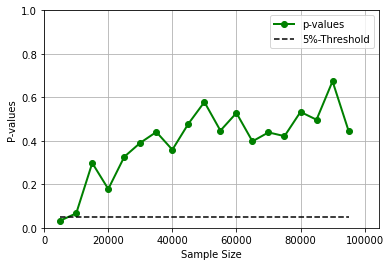

In [15]:
plt.plot(sample_sizes,p_values,marker='o',linewidth=2,color='g')
plt.grid()
plt.xlim(0,max(sample_sizes)*1.1)
plt.ylim(0,1)
plt.plot([min(sample_sizes),max(sample_sizes)],[0.05,0.05],color='black',linestyle='--')
plt.xlabel('Sample Size')
plt.ylabel('P-values')
plt.legend(['p-values','5%-Threshold'])
plt.show()

Looking at the graph above, it is clear that the sample size must increase. As a matter of fact, n = 4719 is used for the sample size, we actually see that p-value is lower that the threshold, meaning that we can reject the null hypothesis, which is not correct as explained above. 

### 5.2. Results for Larger Sample Size
At this point we might perform the analysis again using a lager sample. Looking at the graph above, we might consider a value equal to 50,000.

__NOTE__: In this case can be done since the data available is large, but generally speaking this does not reflect the typical real conditions, since we need to define _at priori_ the sample size, and then investigate the results.

In [16]:
n = 50000 # Selected Sample Size

# Random Sample is selected from the Raw Data split in "Control" and "Treatment" Group.
print('RESULTS\n---------------------------------------------')
sample_contr = rd[rd['group']=='control'] ['converted'].sample(n=n, random_state=42)
sample_treat = rd[rd['group']=='treatment'] ['converted'].sample(n=n, random_state=42)

# The statistical results of the random samples are shown
print(f'Control Group Sample Mean          = {sample_contr.mean():.3f}')
print(f'Treatment Group Sample Mean        = {sample_treat.mean():.3f}\n')

# Statistical test is performed between the two groups
z_stat, pval = proportions_ztest([sample_contr.sum(),sample_treat.sum()],
                                 [sample_contr.count(),sample_treat.count()],value=0)
ci_low, ci_upp = proportion_confint([sample_contr.sum(),sample_treat.sum()],
                                    [sample_contr.count(),sample_treat.count()], alpha=0.05, method='normal')             

# Results are printed
print(f'Numer of Sample for Each Group     = {n}')
print(f'Z-statistic                        = {z_stat:.3f}')
print(f'P-value                            = {pval:.3f}\n')
print(f'Control Group 95% Conf. Interval   = [{ci_low[0]:.3f}, {ci_upp[0]:.3f}]')
print(f'Treatment Group 95% Conf. Interval = [{ci_low[1]:.3f}, {ci_upp[1]:.3f}]')

RESULTS
---------------------------------------------
Control Group Sample Mean          = 0.120
Treatment Group Sample Mean        = 0.119

Numer of Sample for Each Group     = 50000
Z-statistic                        = 0.556
P-value                            = 0.578

Control Group 95% Conf. Interval   = [0.117, 0.123]
Treatment Group 95% Conf. Interval = [0.116, 0.122]


### 6.0. Conclusions
Looking at the results for a larger sample, we can be concluded following:
1. The initial estimated sample size was not correct, since it started with a "wrong" value i.e. we assumed that the target conversion rate was 15%, instead the data shows that is much smaller;
2. The confidence interval for the treatment group includes the Control Group base line i.e 12%;
3. The confidence interval does not include our target value of 15%;
4. It appears that the new feature is actually provide worst results.
5. Finally, the high value of p >> 0.05 suggest that ___we cannot reject the Null Hypothesis___ i.e. the attempt of improving the product did not work as expected.